In [1]:
''' 
So far, we have made prediction on individual rows (i.e. given data at time t, will this patient
have sepsis at time t + 6). However, we would expect that if we have multiple time points of
data, we can make better predictions. For example, having 4 hours of data will give us 4 data
points for HR, Hgb, RR, etc. and if we can detect trends across these variables, we may be
able to make better predictions. While there are more complex models out there that have
a better notion of time baked in, one way to incorporate more data is to just flatten 4 hours
of data into a single vector. So now instead of having HR, you would have HR_0, HR_1,
HR_2 and HR_3. 
'''

' \nSo far, we have made prediction on individual rows (i.e. given data at time t, will this patient\nhave sepsis at time t + 6). However, we would expect that if we have multiple time points of\ndata, we can make better predictions. For example, having 4 hours of data will give us 4 data\npoints for HR, Hgb, RR, etc. and if we can detect trends across these variables, we may be\nable to make better predictions. While there are more complex models out there that have\na better notion of time baked in, one way to incorporate more data is to just flatten 4 hours\nof data into a single vector. So now instead of having HR, you would have HR_0, HR_1,\nHR_2 and HR_3. \n'

In [2]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
with open("data/flat_imputed_dataset.pkl", "rb") as f:
    flat_df = pickle.load(f)

In [5]:
'''
Drop un-informative features
'''

drop_cols = []

for flat_col in flat_df.columns:
    flat_col_edited = flat_col.split("_")[0]
    if flat_col_edited in ["FiO2", "Bilirubin_direct", "SBP", "DBP", "Hct", "HospAdmTime", "ICULOS", "EtCO2", "Unit1", "Unit2"]:
        drop_cols.append(flat_col)

print(drop_cols)
flat_df.drop(drop_cols, axis = 1, inplace = True)
flat_df.drop(["patient"], axis = 1, inplace = True)
print(flat_df.shape)

['SBP_0', 'DBP_0', 'EtCO2_0', 'FiO2_0', 'Hct_0', 'SBP_1', 'DBP_1', 'EtCO2_1', 'FiO2_1', 'Hct_1', 'SBP_2', 'DBP_2', 'EtCO2_2', 'FiO2_2', 'Hct_2', 'SBP_3', 'DBP_3', 'EtCO2_3', 'FiO2_3', 'Hct_3', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS']
(186128, 119)


Remove features not selected by relief

In [6]:

selected_features = ['HR', 'Platelets', 'PTT', 'Glucose', 'HCO3', 'WBC', 'Hgb', 'Age', 'Resp', 'Potassium', 'MAP', 'BUN', 'Magnesium', 'Phosphate', 'BaseExcess', "SepsisLabel"]
drop_cols = []

for flat_col in flat_df.columns:
    flat_col_edited = flat_col.split("_")[0]
    if flat_col_edited not in selected_features:
        drop_cols.append(flat_col)

print(drop_cols)
flat_df.drop(drop_cols, axis = 1, inplace = True)
print(flat_df.shape)

['O2Sat_0', 'Temp_0', 'pH_0', 'PaCO2_0', 'SaO2_0', 'AST_0', 'Alkalinephos_0', 'Calcium_0', 'Chloride_0', 'Creatinine_0', 'Bilirubin_direct_0', 'Lactate_0', 'Bilirubin_total_0', 'TroponinI_0', 'Fibrinogen_0', 'O2Sat_1', 'Temp_1', 'pH_1', 'PaCO2_1', 'SaO2_1', 'AST_1', 'Alkalinephos_1', 'Calcium_1', 'Chloride_1', 'Creatinine_1', 'Bilirubin_direct_1', 'Lactate_1', 'Bilirubin_total_1', 'TroponinI_1', 'Fibrinogen_1', 'O2Sat_2', 'Temp_2', 'pH_2', 'PaCO2_2', 'SaO2_2', 'AST_2', 'Alkalinephos_2', 'Calcium_2', 'Chloride_2', 'Creatinine_2', 'Bilirubin_direct_2', 'Lactate_2', 'Bilirubin_total_2', 'TroponinI_2', 'Fibrinogen_2', 'O2Sat_3', 'Temp_3', 'pH_3', 'PaCO2_3', 'SaO2_3', 'AST_3', 'Alkalinephos_3', 'Calcium_3', 'Chloride_3', 'Creatinine_3', 'Bilirubin_direct_3', 'Lactate_3', 'Bilirubin_total_3', 'TroponinI_3', 'Fibrinogen_3', 'Gender']
(186128, 58)


In [7]:
train_df, test_df  = train_test_split(flat_df, test_size = 0.3)
train_df, valid_df = train_test_split(train_df, test_size = 0.3)

In [8]:
print(train_df.shape)
print(train_df.columns)

(91202, 58)
Index(['HR_0', 'MAP_0', 'Resp_0', 'BaseExcess_0', 'HCO3_0', 'BUN_0',
       'Glucose_0', 'Magnesium_0', 'Phosphate_0', 'Potassium_0', 'Hgb_0',
       'PTT_0', 'WBC_0', 'Platelets_0', 'HR_1', 'MAP_1', 'Resp_1',
       'BaseExcess_1', 'HCO3_1', 'BUN_1', 'Glucose_1', 'Magnesium_1',
       'Phosphate_1', 'Potassium_1', 'Hgb_1', 'PTT_1', 'WBC_1', 'Platelets_1',
       'HR_2', 'MAP_2', 'Resp_2', 'BaseExcess_2', 'HCO3_2', 'BUN_2',
       'Glucose_2', 'Magnesium_2', 'Phosphate_2', 'Potassium_2', 'Hgb_2',
       'PTT_2', 'WBC_2', 'Platelets_2', 'HR_3', 'MAP_3', 'Resp_3',
       'BaseExcess_3', 'HCO3_3', 'BUN_3', 'Glucose_3', 'Magnesium_3',
       'Phosphate_3', 'Potassium_3', 'Hgb_3', 'PTT_3', 'WBC_3', 'Platelets_3',
       'Age', 'SepsisLabel'],
      dtype='object')


In [9]:
y_train = np.array(train_df.pop('SepsisLabel'))
y_valid = np.array(valid_df.pop('SepsisLabel'))
y_test  = np.array(test_df.pop('SepsisLabel'))

X_train = np.array(train_df)
X_valid = np.array(valid_df)
X_test  = np.array(test_df)

In [10]:
''' 
Data Normalization and Scaling.
'''

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)


X_train = np.clip(X_train, -5, 5)
X_valid = np.clip(X_valid, -5, 5)
X_test  = np.clip(X_test, -5, 5)


print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

pos_neg_train = len([1 for i in y_train if i == 1]) / len([1 for i in y_train if i == 0])
pos_neg_valid = len([1 for i in y_valid if i == 1]) / len([1 for i in y_valid if i == 0])
pos_neg_test  = len([1 for i in y_test if i == 1]) / len([1 for i in y_test if i == 0])

print(pos_neg_train)
print(pos_neg_valid)
print(pos_neg_test)

(91202, 57)
(39087, 57)
(55839, 57)
0.0023960256748439285
0.0022307692307692306
0.0022256124921475368


In [11]:
'''
Define the model and metrics
'''

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


def make_model(metrics = METRICS, output_bias = None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  NUM_NEURONS = 1024
  DROP_RATE   = 0.5 #50% chance of droping each neuron.
  model = keras.Sequential([
                            keras.layers.Dense(NUM_NEURONS, activation='relu', input_shape=(X_train.shape[-1],)),
                            keras.layers.Dropout(DROP_RATE),
                            keras.layers.Dense(NUM_NEURONS / 2, activation='relu', input_shape=(X_train.shape[-1],)),
                            keras.layers.Dropout(DROP_RATE),
                            keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
                          ])

  model.compile(
                optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=metrics
              )

  return model

''' 
Baseline model
'''

EPOCHS = 100
BATCH_SIZE = 248

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              59392     
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 584,705
Trainable params: 584,705
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.predict(X_train[:10])

array([[0.493107  ],
       [0.46116748],
       [0.4725433 ],
       [0.45197508],
       [0.52193075],
       [0.5161011 ],
       [0.46837455],
       [0.53370965],
       [0.52541524],
       [0.49440524]], dtype=float32)

In [13]:
'''
Set the initial bias to decrease the intial loss
'''
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

initial_bias = np.log([pos_neg_test])
model = make_model(output_bias=initial_bias)
model.predict(X_train[:10])
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6736
Loss: 0.0168


In [14]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [ ]:
'''
Train the baseline model
'''

model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size = BATCH_SIZE / 3,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_valid, y_valid))

In [16]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()


def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.plot([0,1],[0,1])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')


def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [ ]:
plot_metrics(baseline_history)

In [16]:
train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)

In [ ]:
baseline_results = model.evaluate(X_test, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

In [ ]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [ ]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [17]:
'''
Class Weights

The goal is to identify septic patients, but we don't have very many of those positive samples to work with,
so you would want to have the classifier heavily weight the few examples that are available.
You can do this by passing Keras weights for each class through a parameter.
These will cause the model to "pay more attention" to examples from an under-represented class.
'''

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

total = len(y_train)
neg = len([ 1 for y in y_train if y == 0])
pos = len([ 1 for y in y_train if y == 1])
print(pos / total)

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for sepsis negative class: {:.2f}'.format(weight_for_0))
print('Weight for sepsis positve class: {:.2f}'.format(weight_for_1))

0.002390298458367141
Weight for sepsis negative class: 0.50
Weight for sepsis positve class: 209.18


In [25]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_train,
    y_train,
    batch_size = int(BATCH_SIZE / 3), # 3,4
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_valid, y_valid),
    class_weight=class_weight)

Epoch 1/100
1113/1113 [==============================] - ETA: 0s - loss: 1.9866 - tp: 113.0000 - fp: 29802.0000 - tn: 116897.0000 - fn: 229.0000 - accuracy: 0.7958 - precision: 0.0038 - recall: 0.3304 - auc: 0.5743 - prc: 0.0033

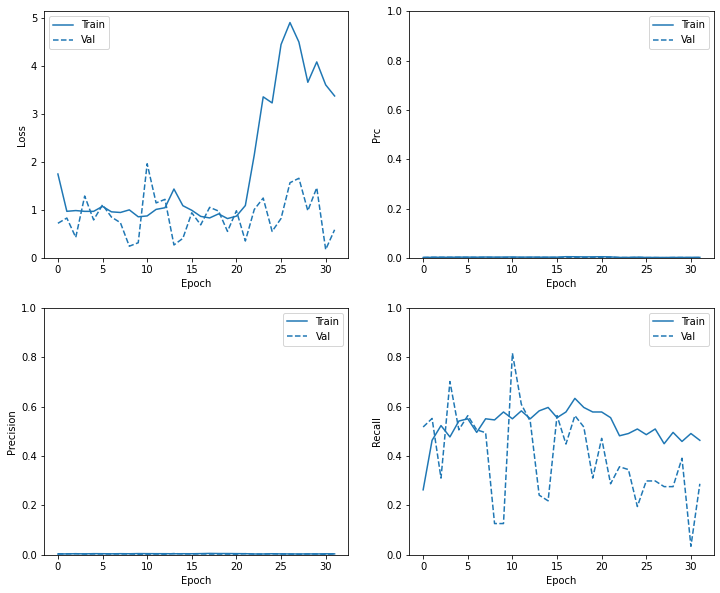

In [19]:
plot_metrics(weighted_history)

In [20]:
train_predictions_weighted = weighted_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_weighted  = weighted_model.predict(X_test, batch_size=BATCH_SIZE)

loss :  0.3566921651363373
tp :  31.0
fp :  7927.0
tn :  47788.0
fn :  93.0
accuracy :  0.8563727736473083
precision :  0.00389545108191669
recall :  0.25
auc :  0.6208020448684692
prc :  0.004772957414388657



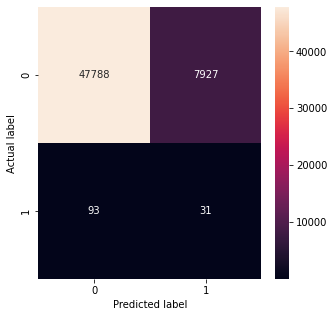

In [21]:
weighted_results = weighted_model.evaluate(X_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted)


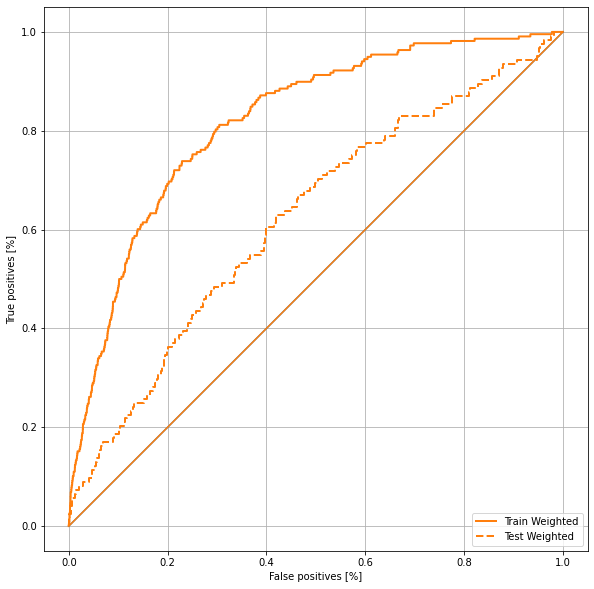

In [22]:
plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

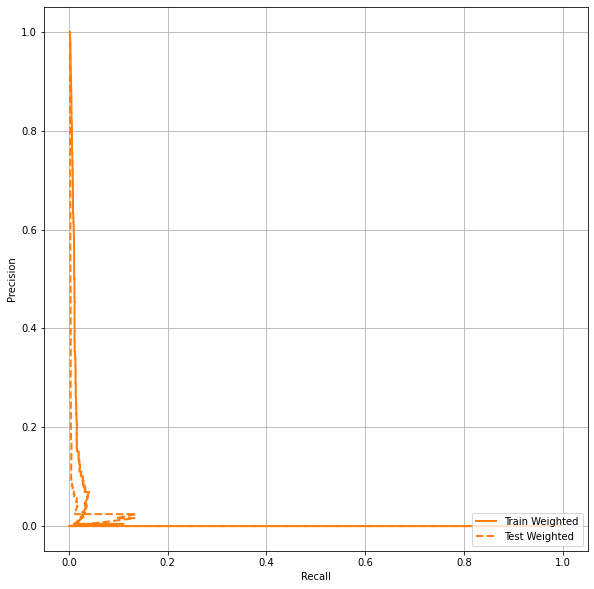

In [23]:
plot_prc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted",  y_test, test_predictions_weighted, color=colors[1], linestyle='--')
plt.legend(loc='lower right')

In [16]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE Algo. to train data.
smote = SMOTE(sampling_strategy = 'minority') #oversample minortiy class -> sepsiLabel = 1
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Ratio between sepsis pos. and sepsis neg. patients: ")
print(len([1 for i in y_train_smote if i == 1]) / len([1 for i in y_train_smote if i == 0]))
print(X_train_smote.shape)

Ratio between sepsis pos. and sepsis neg. patients: 
1.0
(181984, 118)


In [17]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_train_smote,
    y_train_smote,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_valid, y_valid))

Epoch 1/100
89/89 [==============================] - 7s 59ms/step - loss: 0.6459 - tp: 61505.0000 - fp: 22344.0000 - tn: 107652.0000 - fn: 29570.0000 - accuracy: 0.7652 - precision: 0.7335 - recall: 0.6753 - auc: 0.8450 - prc: 0.7331 - val_loss: 0.2403 - val_tp: 20.0000 - val_fp: 3647.0000 - val_tn: 35357.0000 - val_fn: 63.0000 - val_accuracy: 0.9051 - val_precision: 0.0055 - val_recall: 0.2410 - val_auc: 0.6530 - val_prc: 0.0038
Epoch 2/100
89/89 [==============================] - 4s 49ms/step - loss: 0.2439 - tp: 83556.0000 - fp: 9677.0000 - tn: 81315.0000 - fn: 7436.0000 - accuracy: 0.9060 - precision: 0.8962 - recall: 0.9183 - auc: 0.9619 - prc: 0.9481 - val_loss: 0.1102 - val_tp: 8.0000 - val_fp: 1512.0000 - val_tn: 37492.0000 - val_fn: 75.0000 - val_accuracy: 0.9594 - val_precision: 0.0053 - val_recall: 0.0964 - val_auc: 0.6231 - val_prc: 0.0034
Epoch 3/100
89/89 [==============================] - 4s 48ms/step - loss: 0.1273 - tp: 87997.0000 - fp: 4921.0000 - tn: 86071.0000 - fn:

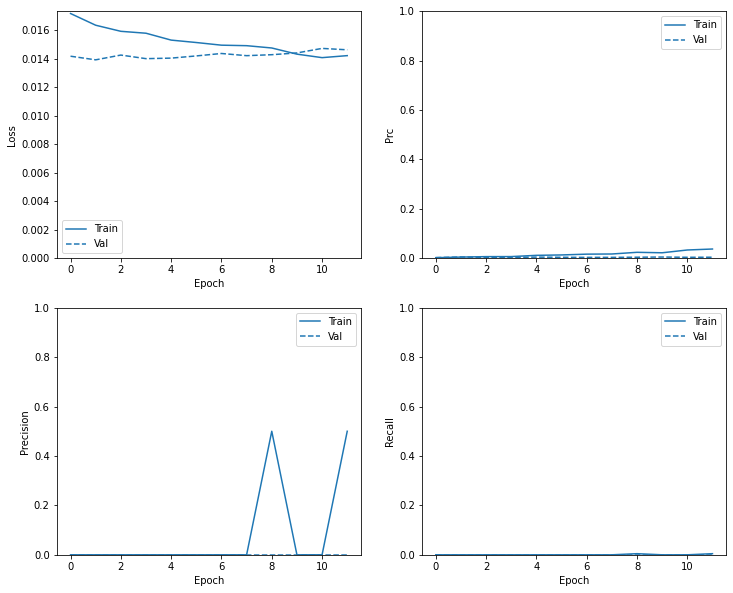

In [57]:
plot_metrics(baseline_history)

In [18]:
train_predictions_weighted = weighted_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_weighted  = weighted_model.predict(X_test, batch_size=BATCH_SIZE)

loss :  0.2404148280620575
tp :  31.0
fp :  5216.0
tn :  50487.0
fn :  105.0
accuracy :  0.904708206653595
precision :  0.005908138118684292
recall :  0.22794117033481598
auc :  0.6267895102500916
prc :  0.003957920242100954



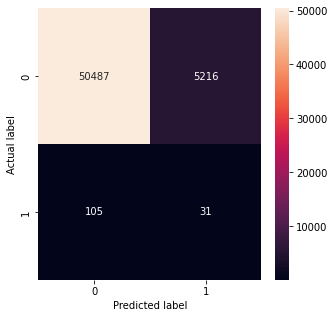

In [19]:
weighted_results = weighted_model.evaluate(X_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted)